# Double pendulum

# Double pendulum problem

## Description

<div align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg" alt="Double pendulum" width="150"/>
</div>

## Challenge

Solve the double pendulum problem using an **ODE** solver. You can solve using scipy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) function. Use the following initial conditions: $g=9.81$, $m_1=2$, $m_2=1$, $L_1=2$, $L_2=1$, $\theta_1=1$, $\dot{\theta_1}=-3$, $\theta_2=-1$, $\dot{\theta_2}=5$, $t=0$, $dt=0.04$, $t_N=40$.

1. Solve the double-pendulum problem using `scipy`, `numpy`, and if needed `sympy` (for symbolic computations such as solving and simplifying the equations).
2. Visualize the motion of the pendulum using `matplotlib`.
3. *Optional*: Plot the evolution of the Lagrangian of the system.

In [1]:
import numpy as np
import sympy as sym
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

sym.init_printing()

## Define the system of equation

In [2]:
t, m1, m2, g, L1, L2 = sym.symbols("t m_1 m_2 g L_1 L_2")
t, m1, m2, g, L1, L2

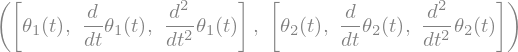

In [3]:
theta1, theta2 = sym.symbols(r"\theta_1, \theta_2", cls=sym.Function)

# theta1
theta1 = theta1(t)
theta1_d = sym.diff(theta1, t)
theta1_dd = sym.diff(theta1_d, t)

# theta2
theta2 = theta2(t)
theta2_d = sym.diff(theta2, t)
theta2_dd = sym.diff(theta2_d, t)

[theta1, theta1_d, theta1_dd], [theta2, theta2_d, theta2_dd]

The positions of the mass is given as:

* $\mathbf{x}_1 = (x_1, y_1) = L_1(\sin \theta_1, -\cos \theta_1)$
* $\mathbf{x}_2 = (y_2, y_2) = (L_1 \sin \theta_1 + L_2 \sin \theta_2, -L_1 \cos \theta_1 - L_2 \cos \theta_2)$

In [4]:
x1 = L1 * sym.sin(theta1)
y1 = -L1 * sym.cos(theta1)

x2 = x1 + L2 * sym.sin(theta2)
y2 = y1 - L2 * sym.cos(theta2)

[x1, y1], [x2, y2]

## Define Lagrangian

The kinetic energy ($T$) of the system is:

$$
T = T_1 + T_2 = \frac{1}{2} m_1 (\dot{x}_1^2 + \dot{y}_1^2) + \frac{1}{2} m_2 (\dot{x}_2^2 + \dot{y}_2^2)
$$

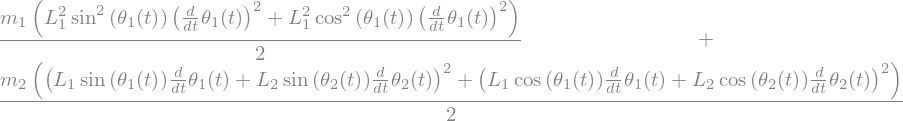

In [5]:
T = sym.Rational(1, 2) * (
    m1 * (sym.diff(x1, t) ** 2 + sym.diff(y1, t) ** 2)
    + m2 * (sym.diff(x2, t) ** 2 + sym.diff(y2, t) ** 2)
)
T

The total potential energy $V$ of the system is given as:

$$
V = V_1 + V_2 = m_1 g y_1 + m_2 g y_2
$$

In [6]:
V = m1 * g * y1 + m2 * g * y2
V

The Lagrangian of the system is given as:

$$
L = (T_1 + T_2) - (V_1 + V_2)
$$

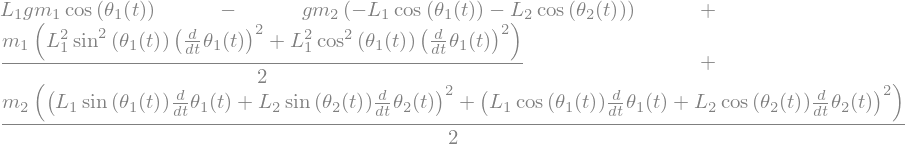

In [7]:
L = T - V
L

## Define the Lagrange's equations:

The equation of motion is derived by balancing the linear and angular momentum of the system, by using the Lagrange's equation:

$$
\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}_1} = 0
$$

$$
\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}_2} = 0
$$

CPU times: user 1.01 s, sys: 17.8 ms, total: 1.03 s
Wall time: 1.03 s


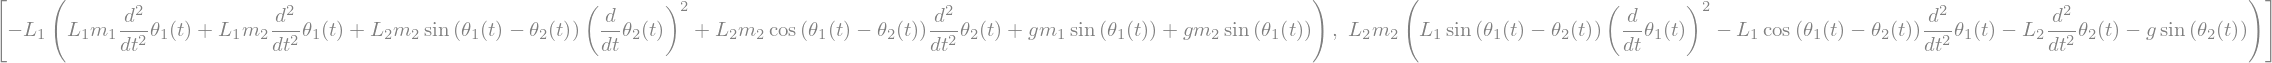

In [8]:
%%time
Leqs = [
    (sym.diff(L, theta1) - sym.diff(sym.diff(L, theta1_d), t)).simplify(),
    (sym.diff(L, theta2) - sym.diff(sym.diff(L, theta2_d), t)).simplify(),
]
Leqs

### Solve system of equations for $\ddot{\theta_1}$ and $\ddot{\theta_2}$

CPU times: user 1.81 s, sys: 14.5 ms, total: 1.83 s
Wall time: 1.83 s


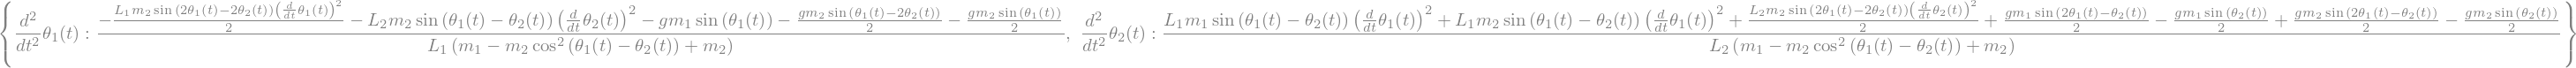

In [9]:
%%time
sys = sym.solve(Leqs, (theta1_dd, theta2_dd), simplify=True, rational=True)
sys

### Numerical simulation

1. Convert 2 2nd-order to 4 1rd-order ode: Solve by substitution for second-order terms:

$$
\begin{bmatrix}
\omega_1\\
\omega_2
\end{bmatrix} \equiv
\begin{bmatrix}
d\theta_1/dt\\
d\theta_2/dt
\end{bmatrix}
\qquad \Rightarrow \qquad
\begin{bmatrix}
d\omega_1/dt\\
d\omega_2/dt
\end{bmatrix} = 
\begin{bmatrix}
d^2\theta_1/dt^2\\
d^2\theta_2/dt^2
\end{bmatrix}
$$

2. Define the state vector $S$ we want to solve is defined as:

$$
S = \begin{bmatrix}
\theta_1\\
\theta_2\\
\omega_1\\
\omega_2
\end{bmatrix}
\qquad \Rightarrow \qquad
\frac{dS}{dt} = \begin{bmatrix}
d\theta_1/dt\\
d\theta_2/dt\\
d\omega_1/dt\\
d\omega_2/dt
\end{bmatrix}
$$

In [10]:
dtheta1dt_f = sym.lambdify(theta1_d, theta1_d)
dtheta2dt_f = sym.lambdify(theta2_d, theta2_d)

domega1dt_f = sym.lambdify(
    (m1, m2, g, L1, L2, theta1, theta2, theta1_d, theta2_d), sys[theta1_dd]
)
domega2dt_f = sym.lambdify(
    (m1, m2, g, L1, L2, theta1, theta2, theta1_d, theta2_d), sys[theta2_dd]
)

In [11]:
def dSdt(S, t):
    # State
    theta1, theta2, omega1, omega2 = S
    # Derivatives
    return [
        dtheta1dt_f(omega1),
        dtheta2dt_f(omega2),
        domega1dt_f(m1, m2, g, L1, L2, theta1, theta2, omega1, omega2),
        domega2dt_f(m1, m2, g, L1, L2, theta1, theta2, omega1, omega2),
    ]

### Numerically solve

In [12]:
# Conditions
t = np.arange(0, 40 + 0.01, 0.04)
g = 9.81
m1, m2 = 2, 1
L1, L2 = 2, 1
theta1_0, theta2_0 = 1, -1
omega1_0, omega2_0 = -3, 5

In [13]:
%%time
sol = scipy.integrate.odeint(dSdt, y0=[theta1_0, theta2_0, omega1_0, omega2_0], t=t).T

CPU times: user 155 ms, sys: 1.48 ms, total: 156 ms
Wall time: 155 ms


In [14]:
def get_pos(theta1, theta2, L1, L2):
    return (
        L1 * np.sin(theta1),
        -L1 * np.cos(theta1),
        L1 * np.sin(theta1) + L2 * np.sin(theta2),
        -L1 * np.cos(theta1) - L2 * np.cos(theta2),
    )


x1, y1, x2, y2 = get_pos(sol[0], sol[1], L1, L2)

In [15]:
def animate(i):
    x = [0, x1[i], x2[i]]
    y = [0, y1[i], y2[i]]
    hist_x.append(x[2])
    hist_y.append(y[2])

    line.set_data(x, y)
    trace.set_data(hist_x[-50:], hist_y[-50:])
    text.set_text(f"t = {i}")
    return line, trace, text


fig, ax = plt.subplots(figsize=(6, 6), dpi=80)
(line,) = ax.plot([], [], "o-", c="tab:blue", lw=3, markersize=8)
(trace,) = ax.plot([], [], "-", c="k", lw=1, alpha=0.75)
ax.axis([-4, 4, -4, 4])

text = ax.text(0.05, 0.9, "", fontsize=15, transform=ax.transAxes)
hist_x, hist_y = [], []

ani = animation.FuncAnimation(fig, animate, frames=1000, interval=10, blit=True)
plt.close()
HTML(ani.to_html5_video())